# Predicting house prices using multiple linear regression

The King County Housing dataset that was used contains information about various features for houses. This project aims towards coming up with a multiple regression model that can effectively predict house prices.

**Regression analysis problem**

This analysis aims towards determining a combination of features that is best for constructing a model to predict house prices. The results will help home owners interested in selling their homes by informing them on the important factors to consider in order to improve sale prices.

In [99]:
#importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import seaborn as sns

In [3]:
#loading and previewing the dataframe.
model = pd.read_csv("kc_house_data.csv")
model.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
#checking the datatypes 
model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

The dataset contains 21613 entries and 21 columns. Majority of the columns contain numeric data hence suitable for linear regression. Waterfront, view and yr_renovated variables have missing values.

**Dealing with missing data**

In [5]:
#checking the value counts for waterfront
model['waterfront'].value_counts()


NO     19075
YES      146
Name: waterfront, dtype: int64

In [6]:
#checking value counts for view 
model['view'].value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

In [7]:
#checking value counts for yr_renovated
model['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [8]:
#the columns with missing values are filled with the median
model['yr_renovated'].fillna(value = model['yr_renovated'].median(), inplace=True)

In [9]:
#the missing values are filled with none to indicate missing data.
model['waterfront'].fillna('None', inplace=True)

In [10]:
#missing values are filled with none to indicate missing data
model['view'].fillna('None', inplace=True)

In [11]:
#checking the missing value count to confirm that missing values are eliminated.
for column in list(model.columns):
    print(column, sum(model[column].isnull()))

id 0
date 0
price 0
bedrooms 0
bathrooms 0
sqft_living 0
sqft_lot 0
floors 0
waterfront 0
view 0
condition 0
grade 0
sqft_above 0
sqft_basement 0
yr_built 0
yr_renovated 0
zipcode 0
lat 0
long 0
sqft_living15 0
sqft_lot15 0


**Checking for outliers**

Outliers were checked in the bedroom and bathroom columns so that houses that lack both are eliminated. To eliminate these houses which are considered as outliers, another function was defined to drop the rows containing these values.

In [12]:
#defining a function to check for outliers
def find_outliers(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR = q3 - q1
    outliers = df[((df<(q1-1.5*IQR))|(df>(q3+1.5*IQR)))]
    return outliers

In [13]:
bathroom_outliers = find_outliers(model['bathrooms'])
bathroom_outliers

5        4.50
75       4.00
235      4.00
270      4.75
300      5.00
         ... 
21535    4.50
21545    4.00
21560    4.50
21577    3.75
21584    3.75
Name: bathrooms, Length: 561, dtype: float64

In [14]:
bedroom_outliers = find_outliers(model['bedrooms'])
bedroom_outliers

154      1
209      6
232      6
239      6
264      1
        ..
21359    6
21427    1
21503    1
21506    6
21536    1
Name: bedrooms, Length: 530, dtype: int64

**Dealing with Outliers**

In [15]:
#fuction defined to drop outliers 
def drop_outliers(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR =  q3-q1
    outliers = df[~(df<(q1-1.5*IQR))|(df>(q3+1.5*IQR))]
    outliers_dropped = outliers.dropna().reset_index()
    return outliers_dropped

In [16]:
bathroom_outlier = drop_outliers(model['bathrooms'])
bathroom_outlier

,index,bathrooms
0,0,1.00
1,1,2.25
2,2,1.00
3,3,3.00
4,4,2.00
...,...,...
21588,21592,2.50
21589,21593,2.50
21590,21594,0.75
21591,21595,2.50


In [17]:
bedroom_outlier = drop_outliers(model['bedrooms'])
bedroom_outlier

,index,bedrooms
0,0,3
1,1,3
2,2,2
3,3,4
4,4,3
...,...,...
21396,21592,3
21397,21593,4
21398,21594,2
21399,21595,3


**One Hot Encoding**

The values for grade are encoded on a linear scale of 3 to 13 where 3 represents 'poor' while 13 represents 'mansion'. The figure below shows that mansion perform best in terms of price.
The relationship between house grades and prices can clearly be explained by one hot encoding the variables. 

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

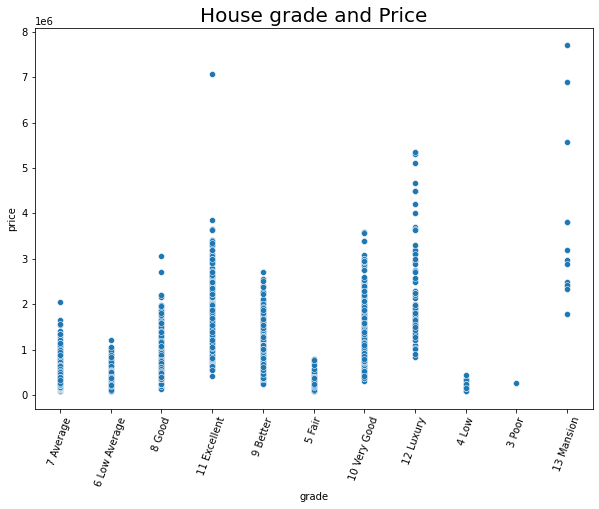

In [18]:
#scatter plot representing the relationship between grade and price
plt.figure(figsize=(10,7))
sns.scatterplot(x=model['grade'], y=model['price'])
plt.title('House grade and Price', fontsize=20)
plt.xticks(rotation=70)

Mansions tend to have a higher price which may be due to the materials used and design implemented during construction. A building graded as poor tends to have a low price which may be attributed to lack of design and less expensive materials used during construction.

In [19]:
#Columns are dropped to avoid dummy variable trap.
#new variables are joined to the data set
grade_df = pd.get_dummies(model['grade'], drop_first=True) 
model_df = model.drop('grade',axis = 1)
model_df = model_df.join(grade_df)
model_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,11 Excellent,12 Luxury,13 Mansion,3 Poor,4 Low,5 Fair,6 Low Average,7 Average,8 Good,9 Better
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,None,NONE,...,0,0,0,0,0,0,0,1,0,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,0,0,0,0,0,0,0,1,0,0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,0,0,0,0,0,0,1,0,0,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,0,0,0,0,0,0,0,1,0,0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,0,0,0,0,0,0,0,0,1,0
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,0,0,0,0,0,0,0,0,1,0
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,0,0,0,0,0,0,0,1,0,0
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,None,NONE,...,0,0,0,0,0,0,0,0,1,0


**Correlations and multicollinearity**

The main aim is to check on the variables that are strongly correlated with price since they will be essential for our model.

findfont: Font family ['Silom'] not found. Falling back to DejaVu Sans.


<AxesSubplot:>

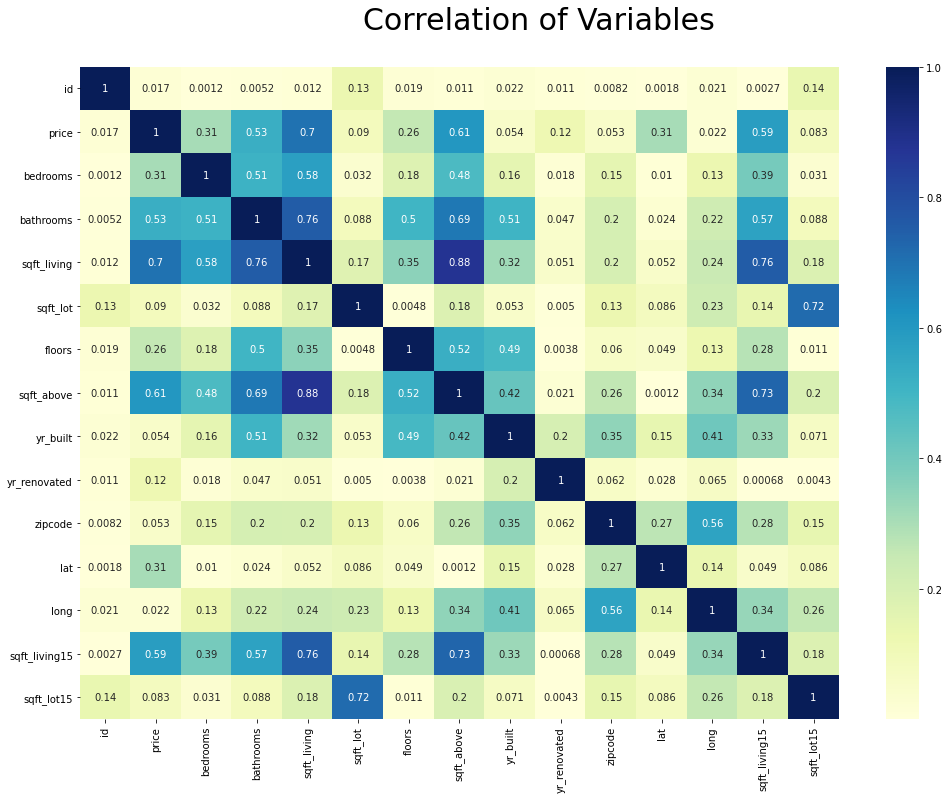

In [20]:
corr = model.corr().abs()
fig, ax=plt.subplots(figsize=(17,12))
fig.suptitle('Correlation of Variables', fontsize=30, y=.95, fontname='Silom')
heatmap = sns.heatmap(corr, cmap='YlGnBu', annot=True)
heatmap

Majority of the variables related to size of homes like number of rooms and square foot are highly correlated with each other. However, we would preferrably want to include models that are highly correlated with our y variable. 

In [21]:
numeric_vars = ['bedrooms', 'bathrooms', 'sqft_living', 
       'sqft_lot','floors', 'sqft_above', 'yr_built', 
       'yr_renovated']
model_defined = model.loc[:,numeric_vars]
model_defined.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated
0,3,1.00,1180,5650,1.0,1180,1955,0.0
1,3,2.25,2570,7242,2.0,2170,1951,1991.0
2,2,1.00,770,10000,1.0,770,1933,0.0
3,4,3.00,1960,5000,1.0,1050,1965,0.0
4,3,2.00,1680,8080,1.0,1680,1987,0.0


In [92]:
#checking for correlation of variables with price
Variables = []
correlations = []
for x, correlation in corr['price'].T.iteritems():
    if correlation >= .30 and x != 'price':
        Variables.append(x)
        correlations.append(correlation)
corr_price = pd.DataFrame({'Correlations':correlations, 'Variables': Variables}).sort_values(by=['Correlations'], ascending=False)

In [93]:
print('Correlations with Price')
display(corr_price)

Correlations with Price


,Correlations,Variables
2,0.701917,sqft_living
3,0.605368,sqft_above
5,0.585241,sqft_living15
1,0.525906,bathrooms
0,0.308787,bedrooms
4,0.306692,lat


A correlation value above .70 is considered high, for all the correlations with price none of the values are above .70. sqft_living, sqft_above, sqft_living15 and bathrooms have the strongest correlation with price.

In [25]:
#checking for multicollinearity
df = model_defined.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df['pairs'] = list(zip(df.level_0, df.level_1))
df.set_index(['pairs'], inplace = True)
df.drop(columns=['level_1', 'level_0'], inplace = True)
# cc for correlation coefficient
df.columns = ['cc']
df.drop_duplicates(inplace=True)
df[(df.cc>.75) & (df.cc<1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.876448
"(bathrooms, sqft_living)",0.755758


 Variables whose correlation with one another exceeds 0.75 will not be included in our model since it implies multicollinearity.
 
 There are two set of variables that are highly correlated with each other: sqft_living with sqft_above and bathrooms with sqft_living. The most appropriate approach would be to drop one variable from each of the pairs since they cannot both be included in one model.

 Since sqft_living has a high correlation with price it is likely to be used in the multiple regression model. sqft_above and bathrooms will most likely be eliminated from our model due to their multicollinearity with sqft_living.

**Simple Linear Regression**

The assumption of linearity, normality and homoscedasticity require a regression model since they are mainly concerned with residuals. Before coming up with the final regression model, simple linear regression analysis was conducted for each of the variables that remained after elimination due to multicollinearity.The final features to be included in our multiple regression model will be decided based on simple linear regression models that will be created.

There are assumptions of the data that have to be checked before creating a multiple linear regression model;

**Linearity** where a linear relationship should exist between the response variable(y) and predictor variable(x).

The data should be independent hence **collinearity** should be avoided between features.

**Homoscedasticity** where variability should be equal across values of independent variables.

**Normality** where the residuals should follow a normal distribution.

From the model summary;
R squared will be checked to determine the amount of variance in the dependent variable that is explained by our model.
P value obtained should be less than 0.05 so that the null hypothesis is rejected. The null hypothesis states that no relationship exists between the response variable and explanatory variables.

A simple linear regression has one explanatory/independent variable and one response/dependent variable. The variables to be used are sqft_living, sqft_living15 and bedrooms.

**1. Sqft living**

In [26]:
#simple linear regression of sqftliving and price
import statsmodels.api as sm
X = model_defined [['sqft_living']]
y= model['price']
sqft_living_model = sm.OLS(endog=y, exog=sm.add_constant(X))
results = sqft_living_model.fit()

**Testing for linearity in sqft living**

Using linear rainbow test to test for linearity;
The null hypothesis states that the relationship is considered linear while the alternative hypothesis states that the relationship is not considered linear.

A low p value compared to the standard alpha value of 0.05 indicates that the model is not linear hence we reject the null hypothesis contrary to what normal p values indicate. A high p value on the other hand, indicates that the model is linear hence the null hypothesis is accepted.

In [27]:
#statistical testing for linearity using rainbow test
from statsmodels.stats.diagnostic import linear_rainbow
linear_rainbow(results)

(1.0880045442869073, 5.8947614341769625e-06)

Log transformation is used when assumptions of linearity are not met hence it is applied to correct non-linearity.

In [28]:
#log transformation to correct non-linearity
model['price'] = np.log(model['price'])
model_defined['sqft_living'] = np.log(model_defined['sqft_living'])

In [29]:
import statsmodels.api as sm
X_transform = model_defined [['sqft_living']]
y_transform= model['price']
sqft_living_model = sm.OLS(endog=y_transform, exog=sm.add_constant(X_transform))
results_transformed = sqft_living_model.fit()

In [30]:
#statistical test for linearity on log transformed variables
from statsmodels.stats.diagnostic import linear_rainbow
linear_rainbow(results_transformed)

(0.9831117825097534, 0.8118960639911326)

The model has obtained a new p value of 0.8 which is higher than the standard alpha of 0.05, the null hypothesis is rejected and the relationship is considered linear.

**Testing for normality in sqft_living**

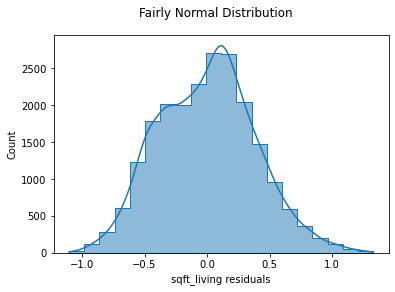

In [31]:
#visualizing normality of sqft_living
fig, ax = plt.subplots()
sns.histplot(results_transformed.resid, bins=20, element="step", kde=True, ax=ax)
ax.set_xlabel("sqft_living residuals")
fig.suptitle("Fairly Normal Distribution");

The histogram shows that the residual is a bit skewed not so normal.

**Testing for homoscedasticity in sqft_living**

Using Goldfeld Quandt Test to test for homoscedasticity;
The null hypothesis is homoscedasticity while the alternative hypothesis is heteroscedasticity.

A low p value indicates inequality in variance hence heteroscedasticity and rejection of the null hypothesis. A high p value on the other hand, indicates equality in variance hence homoscedasticity and failure to reject the null hypothesis.

In [32]:
#testing for equality in variance
from statsmodels.stats.diagnostic import het_goldfeldquandt
het_goldfeldquandt(y_transform, X_transform, alternative='two-sided')

(0.9870640130120426, 0.4987466793430657, 'two-sided')

The generated data displays a p value of 0.4 which is higher than the alpha value of 0.05. We therefore fail to reject the null hypothesis and conclude that the generated model is homoscedastic.

**2. Bedrooms**

In [33]:
import statsmodels.api as sm
X_rm = model_defined[['bedrooms']]
y_rm= model['price']
bedroom_model = sm.OLS(endog=y, exog=sm.add_constant(X))
results_rm = bedroom_model.fit()

**Testing for linearity in bedrooms**

In [34]:
#using rainbow test to statistically test for linearity
from statsmodels.stats.diagnostic import linear_rainbow
linear_rainbow(results_rm)

(0.9774213050674848, 0.8822865481367497)

The p value obtained 0.8 is greater than 0.05 we therefore fail to reject the null hypothesis and conclude that the relationship is linear.


**Testing for normality in bedrooms**

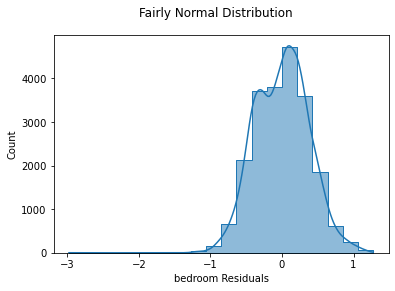

In [35]:
#visualizing normality of number of bedrooms
fig, ax = plt.subplots()
sns.histplot(results_rm.resid, bins=20, element="step", kde=True, ax=ax)
ax.set_xlabel("bedroom Residuals")
fig.suptitle("Fairly Normal Distribution");

The histogram shows that the distribution is fairly normal.

**Testing for homoscedasticity in bedrooms**

In [36]:
#testing for equality in variance using goldfeld test
from statsmodels.stats.diagnostic import het_goldfeldquandt
het_goldfeldquandt(y_rm, X_rm, alternative='two-sided')

(1.0766213828823155, 0.00012544496759894804, 'two-sided')

In [37]:
#log transformation to correct non-linearity
model['price'] = np.log(model['price'])
model_defined['bedrooms'] = np.log(model_defined['bedrooms'])

In [38]:
X_bed = model_defined[['bedrooms']]
y_bed= model['price']
bedroom_models = sm.OLS(endog=y_bed, exog=sm.add_constant(X_bed))
results_bed = bedroom_models.fit()

In [39]:
#testing for equality in variance of log transformed variables 
#goldfeld quandt test.
het_goldfeldquandt(y_bed, X_bed, alternative='two-sided')

(0.9810923289039114, 0.32132757376012455, 'two-sided')

The p value obtained 0.3 is greater than 0.05. We therefore fail to reject the  null hypothesis and conclude that the generated model is homoscedastic.

**3.Sqft Living of nearest 15 neighbours**

In [40]:
import statsmodels.api as sm
X_sqft = model[['sqft_living15']]
y_sqft= model['price']
sqft_model = sm.OLS(endog=y, exog=sm.add_constant(X))
results_sqft = sqft_model.fit()

**Test for linearity for sqft_living15**

In [41]:
#using rainbow test to statistically test for linearity
from statsmodels.stats.diagnostic import linear_rainbow
linear_rainbow(results_sqft)

(0.9721856834322317, 0.9286116155976124)

The p value obtained of 0.9 is greater than the alpha value of 0.05. We therefore fail to reject the null hypothesis and conclude that the relationship is linear.

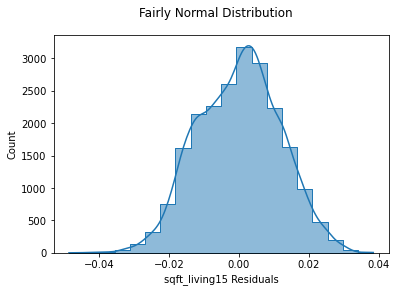

In [96]:
fig, ax = plt.subplots()
sns.histplot(results_sqft.resid, bins=20, element="step", kde=True, ax=ax)
ax.set_xlabel("sqft_living15 Residuals")
fig.suptitle("Fairly Normal Distribution");

The histogram shows that the distribution is fairly normal

**Test for homoscedasticity for sqft_living15**

In [82]:
#Testing for equality of variance
#goldfeld quandt test.
het_goldfeldquandt(y_sqft, X_sqft, alternative='two-sided')

(1.065803949952988, 0.0009305140550029924, 'two-sided')

In [83]:
#log transformation to correct heteroscedasticity
model['price'] = np.log(model['price'])
model['sqft_living15'] = np.log(model['sqft_living15'])

In [84]:
X_sqft15 = model[['sqft_living15']]
y_sqft15= model['price']
sqft15_model = sm.OLS(endog=y, exog=sm.add_constant(X))
results_sqft = sqft15_model.fit()

In [85]:
#goldfeldquandt test on log transformed variables
het_goldfeldquandt(y_sqft15, X_sqft15, alternative='two-sided')

(0.9999908193809578, 0.9996191920703449, 'two-sided')

The p value obtained of 0.9 is greater than the alpha value of 0.05, we therefore fail to reject the null hypothesis and conclude that the generated model is homoscedastic.

**Multiple linear regression**

In [55]:
#formulating a multiple linear regression model
#X and y variables are log transformed 
X_multiple = np.log(model[["sqft_living", "bedrooms", "sqft_living15"]])
y= np.log(model["price"])
multiple = sm.OLS (y, sm.add_constant(X_multiple))
regression = multiple.fit()
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     6849.
Date:                Thu, 29 Sep 2022   Prob (F-statistic):               0.00
Time:                        08:36:02   Log-Likelihood:                 66447.
No. Observations:               21597   AIC:                        -1.329e+05
Df Residuals:                   21593   BIC:                        -1.329e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.7079      0.002    381.595      0.000       0.704       0.711
sqft_living       0.0221      0.000     68.776      0.000       0.022       0.023
bedrooms         -0.0076      0.000    -21.490      0.000      -0.008      -0.007
sqft_living15     0.0102      0.000     29.038      0.000       0.010       0.011
==============================================================================
Omnibus:                      133.805   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.930
Skew:                          -0.018   Prob(JB):                     4.01e-21
Kurtosis:                       2.679   Cond. No.                         266.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The adjusted R squared which is used to establish how predictive the model is had a value of 48.8%.This shows that sqft_living, bedrooms and sqft_living15 contributed to 48.8% variations in sale price. The remaining 51.2% is left unexplained showing that sale price is also influenced by other variables apart from those used in our model. This shows the need for further studies to establish these factors.

The model coefficients all display a p value that is below 0.05 hence they are statistically significant. This evidently shows that a relationship exists between the explanatory variables and response variables.

The probability F statistic displays a value that is below 0.05 hence overall, the model is statistically significant.

Since the model has log transformed predictors and log transformed target, the coefficient values are interpreted as percentages. 

sale price coefficient 0.7079 = 70.79%
The regression equation shows that if sqft_living, bedrooms and sqft_living15 are held constant, sale price would be 70.79%. 

sqft_living coefficient 0.02= 2%
For each 1% increase in square footage of living space in the home, there is an associated 2% increase in sale price.

bedrooms coefficient -0.0076= -0.76%
For each 1% increase in number of bedrooms, there is an associated decrease of 0.76% in sale price.

sqft_living15 coefficient 0.01 =1%
For each 1% increase in the square footage of interior housing living space for the nearest 15 neighbors, there is an associated 1% increase in sale price.

**Normality test on the multiple regression model**

The homoscedasticity assumption was checked for each predictor variable when diagnosing the simple linear regression models. To check the normality of the model's residuals a QQ-plot is created to confirm that the residuals fall along a straight line.

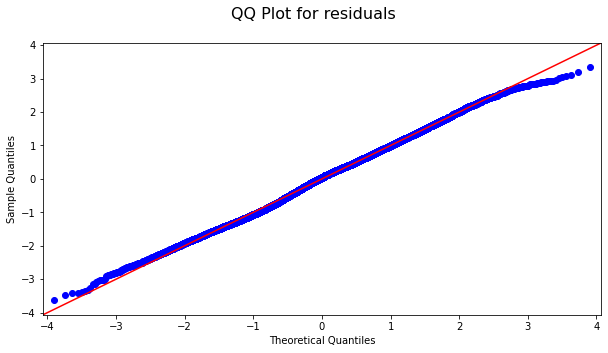

In [89]:
#normality test using a QQ plot
residuals = regression.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.suptitle('QQ Plot for residuals', fontsize=16)
fig.set_size_inches(10, 5)

Since majority of the data points fall along a straight line in the above QQ-plot, the assumption of normality is satisfied. 

**Homoscedasticity test on multiple regression model**

The test for homoscedasticity was done using a scatter plot. The scatter plot was visualized with fitted values on the x axis and model residuals on the y axis. The homoscedasticity assumption holds when the shape of the points is roughly symmetrical across a line.

Text(0.5, 0.99, 'Residuals Scatterplot')

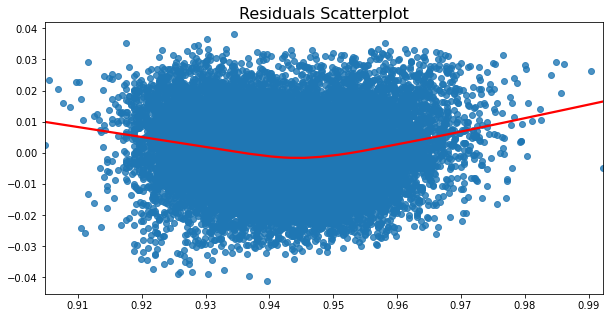

In [97]:
#homoscedasticity test using a scatter plot
plt.figure(figsize=(10,5))
sns.regplot(x=regression.predict(), y=regression.resid, lowess=True, line_kws={'color': 'red'})
plt.title('Residuals Scatterplot', fontsize=16, y=.99)

The points display a roughly symmetrical blob-like shape which is consistent across the x axis. The model therefore satisfies the assumption of homoscedasticity.

**Combination of features that best describe sale prices in a multiple linear regression model**

sqft_living, bedrooms and sqft_living15 are the most effective for predicting house prices using a multiple linear regression model. They have a high correlation with price, low multicollinearity and account for a good percentage of price variability. Multiple regression assumptions are satisfied when the features are included in the model.

**Model Evaluation**

The multiple regression model is evaluated using Adjusted R squared and Root mean Squared Error(RMSE). The lower a RMSE value the better the model.

In [59]:
#fitting a baseline model 
#since sqftliving has the highest correlation with price
#X_baseline = np.log(model[['sqft_living']])
#y = np.log(model['price'])
#baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
#baseline_results = baseline_model.fit()

In [63]:
#calculating adjusted R-squared using statsmodels
regression.rsquared_adj

0.4875256301529265

In [64]:
#non adjusted R-squared
regression.rsquared

0.48759682033210505

Adjusted R squared increases only when increase in variance is explained more than what we would expect to see due to chance. The non adjusted R squared and the adjusted R squared both display similar results.

In [67]:
#calculating root mean squared error
regression.resid**2
rmse = ((regression.resid**2).sum()/len(y))**0.5
rmse

0.011157673585482352

The model is off by 0.01 price in a given prediction. This shows that the average prediction error rate is 1%.

**Conclusion**

Sqft_living, bedrooms and sqft_living15 effectively predict house prices in King County. In order for homeowners to sell their homes at a higher price they should expand the square footage of living space. The square footage of neighbors' living space is a positive predictor of price, but homeowners have less control over this factor. However, they can increase sale price by encouraging neighbors to expand the square footage of their living space. Moreover, they should consider reducing the number of bedrooms since the analysis suggests that additional bedrooms reduce the sale price.

**Limitations**

The model has some limitations:

The variables were log-transformed to satisfy regression assumptions. Therefore, any data to be used with the model would have to be subjected to the same preprocessing. 

Regional differences in housing prices limit applicability of the model to data from other counties. Moreover, removal of outliers from the model suggests that it may be less appropriate in predicting large values.